# Case study: $CH_{4}$ oxidative coupling


## Task summary

As we discussed before, here I have attached the ‘big’ case study focusing on CH4 oxidative coupling. You can see that this paper has a lot of data and catalysts. You should first check the two references (references 20 and 29) to get the data. As this case study can be challenging, it is okay that you only work on part of the catalyst and data. You can also choose Reference 20 as the case study if that one is easier for you. The papers have used some ML, but there is no much overlap between their work and our thought. We can see in the end if symbolic regression can help us discover some additional physical insight.

 

Once you finish reading the three papers, we can have a quick chat before you work on this case study – you can tell us what you plan to do so that we know it is achievable within the time limit.

In [1]:
#import some useful libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.random import check_random_state
from sympy import *

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import the Modified OCM Dataset

In [3]:
# Import OCM dataset 
from io import StringIO
OCM = pd.read_csv('https://raw.githubusercontent.com/jimmmmmmmyzzy/Towards-distilling-physical-laws-in-heterogeneous-catalysis-with-symbolic-regression/main/OCM_dataset_modified%20.csv'
                 ,index_col=[0])  
OCM.head()

,Name,M1,M1_atom_number,M2,M2_atom_number,M3,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
1,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,8.5,4.3,0.50,2,37.04,6.29,0.70,5.59,31.29,5.76,16.98,1.89,15.09,84.48,15.55,5.2,0.129931,1.39,1.66,1.62,1.55,0.93,1.7
2,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,20,3.0,11.3,5.7,0.38,2,26.83,5.34,0.55,4.79,21.62,3.12,19.90,2.05,17.85,80.58,11.63,5.2,0.144418,1.39,1.66,1.62,1.55,0.93,1.7
3,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
4,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,9.6,3.2,0.50,3,24.03,6.54,0.65,5.89,22.34,2.86,27.22,2.70,24.51,92.97,11.90,5.2,0.135273,1.39,1.66,1.62,1.55,0.93,1.7


In [4]:
control = OCM #we import all the data points

# Input & Target Variables

In [5]:
frames = [ control.iloc[:,2:3],control.iloc[:,4:5], control.iloc[:,6:], control.iloc[:,15:20], control.iloc[:,20:21], control.iloc[:,32:33], control.iloc[:,33:40]]
result = pd.concat(frames, axis=1)
result.head()

,M1_atom_number,M2_atom_number,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,5.7,2.8,0.75,2,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
1,25,11,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,8.5,4.3,0.50,2,37.04,6.29,0.70,5.59,31.29,5.76,16.98,1.89,15.09,84.48,15.55,5.2,0.129931,1.39,1.66,1.62,1.55,0.93,1.7,15,2.3,8.5,4.3,0.50,2,5.2,0.129931,1.39,1.66,1.62,1.55,0.93,1.7
2,25,11,74,BN,4,0.37,0.185,40,40,20,900,20,3.0,11.3,5.7,0.38,2,26.83,5.34,0.55,4.79,21.62,3.12,19.90,2.05,17.85,80.58,11.63,5.2,0.144418,1.39,1.66,1.62,1.55,0.93,1.7,20,3.0,11.3,5.7,0.38,2,5.2,0.144418,1.39,1.66,1.62,1.55,0.93,1.7
3,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,6.4,2.1,0.75,3,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
4,25,11,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,9.6,3.2,0.50,3,24.03,6.54,0.65,5.89,22.34,2.86,27.22,2.70,24.51,92.97,11.90,5.2,0.135273,1.39,1.66,1.62,1.55,0.93,1.7,15,2.3,9.6,3.2,0.50,3,5.2,0.135273,1.39,1.66,1.62,1.55,0.93,1.7


In [6]:
result = control[control.loc[:]!=0].dropna()

In [7]:
result.head()

,Name,M1,M1_atom_number,M2,M2_atom_number,M3,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
1,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,15,2.3,8.5,4.3,0.50,2,37.04,6.29,0.70,5.59,31.29,5.76,16.98,1.89,15.09,84.48,15.55,5.2,0.129931,1.39,1.66,1.62,1.55,0.93,1.7
2,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,20,3.0,11.3,5.7,0.38,2,26.83,5.34,0.55,4.79,21.62,3.12,19.90,2.05,17.85,80.58,11.63,5.2,0.144418,1.39,1.66,1.62,1.55,0.93,1.7
3,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
4,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,15,2.3,9.6,3.2,0.50,3,24.03,6.54,0.65,5.89,22.34,2.86,27.22,2.70,24.51,92.97,11.90,5.2,0.135273,1.39,1.66,1.62,1.55,0.93,1.7


In [8]:
result.shape

(8192, 40)

In [9]:
#X_raw = result[["M1_atom_number", "M2_atom_number", "M3_atom_number", "BET_surface_area", "Temp", "Ar_flow", "CH4_flow", "O2_flow", "CH4/O2", "M1_mol%", "M2_mol%", "M3_mol%", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw = result[["CH4_flow", "O2_flow", "Ar_flow", "CT", "Temp", "CH4/O2", "BET_surface_area", "M1_mol%", "M2_mol%", "M3_mol%", "M1_atom_number", "M2_atom_number", "M3_atom_number", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw.describe()



,CH4_flow,O2_flow,Ar_flow,CT,Temp,CH4/O2,BET_surface_area,M1_mol%,M2_mol%,M3_mol%,M1_atom_number,M2_atom_number,M3_atom_number,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
count,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000
mean,6.734460,2.032471,6.248547,0.543400,795.968628,3.748047,489.444885,40.263672,39.604492,20.131836,30.893433,14.053223,69.789062,1.471379,1.655585,1.609473,1.567273,0.980668,1.760532
std,3.321723,1.200335,3.878771,0.154179,65.193886,1.478696,267.876202,1.602345,2.403517,0.801172,11.970776,9.359169,10.818146,0.211709,0.182658,0.027045,0.230204,0.192575,0.155511
min,2.000000,0.400000,1.500000,0.380000,700.000000,2.000000,1.500000,40.000000,25.000000,20.000000,22.000000,3.000000,42.000000,1.220000,1.220000,1.540000,1.100000,0.820000,1.700000
25%,4.000000,1.200000,3.000000,0.380000,750.000000,2.000000,300.000000,40.000000,40.000000,20.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
50%,6.400000,1.800000,6.000000,0.500000,800.000000,3.000000,650.000000,40.000000,40.000000,20.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
75%,9.600000,2.800000,8.000000,0.750000,850.000000,4.000000,650.000000,40.000000,40.000000,20.000000,29.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
max,14.600000,5.700000,14.000000,0.750000,900.000000,6.000000,650.000000,50.000000,40.000000,25.000000,72.000000,56.000000,74.000000,2.070000,2.150000,1.620000,2.200000,1.830000,2.160000


In [10]:
y = result["rate_constant"]
y.describe()


count    8192.000000
mean        0.133368
std         0.091792
min         0.004004
25%         0.064737
50%         0.114411
75%         0.179118
max         0.616328
Name: rate_constant, dtype: float64

(array([2081., 2409., 1863.,  959.,  443.,  239.,  124.,   51.,   16.,
           7.]),
 array([0.00400401, 0.06523637, 0.12646873, 0.18770109, 0.24893345,
        0.31016582, 0.37139818, 0.43263054, 0.4938629 , 0.55509527,
        0.61632763]),
 <BarContainer object of 10 artists>)

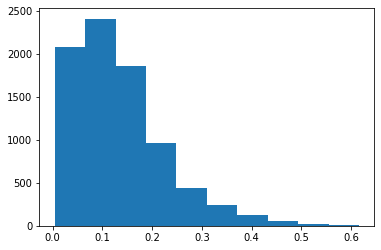

In [11]:
plt.hist(y)

# Correlation Analysis

In [12]:
#X_raw = result[["M1_atom_number", "M2_atom_number", "M3_atom_number", "BET_surface_area", "Temp", "Ar_flow", "CH4_flow", "O2_flow", "CH4/O2", "M1_mol%", "M2_mol%", "M3_mol%", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_new = result[["rate_constant", "CH4_flow", "O2_flow", "Ar_flow", "CT", "Temp", "CH4/O2", "BET_surface_area", "M1_mol%", "M2_mol%", "M3_mol%", "M1_atom_number", "M2_atom_number", "M3_atom_number", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]


<AxesSubplot:>

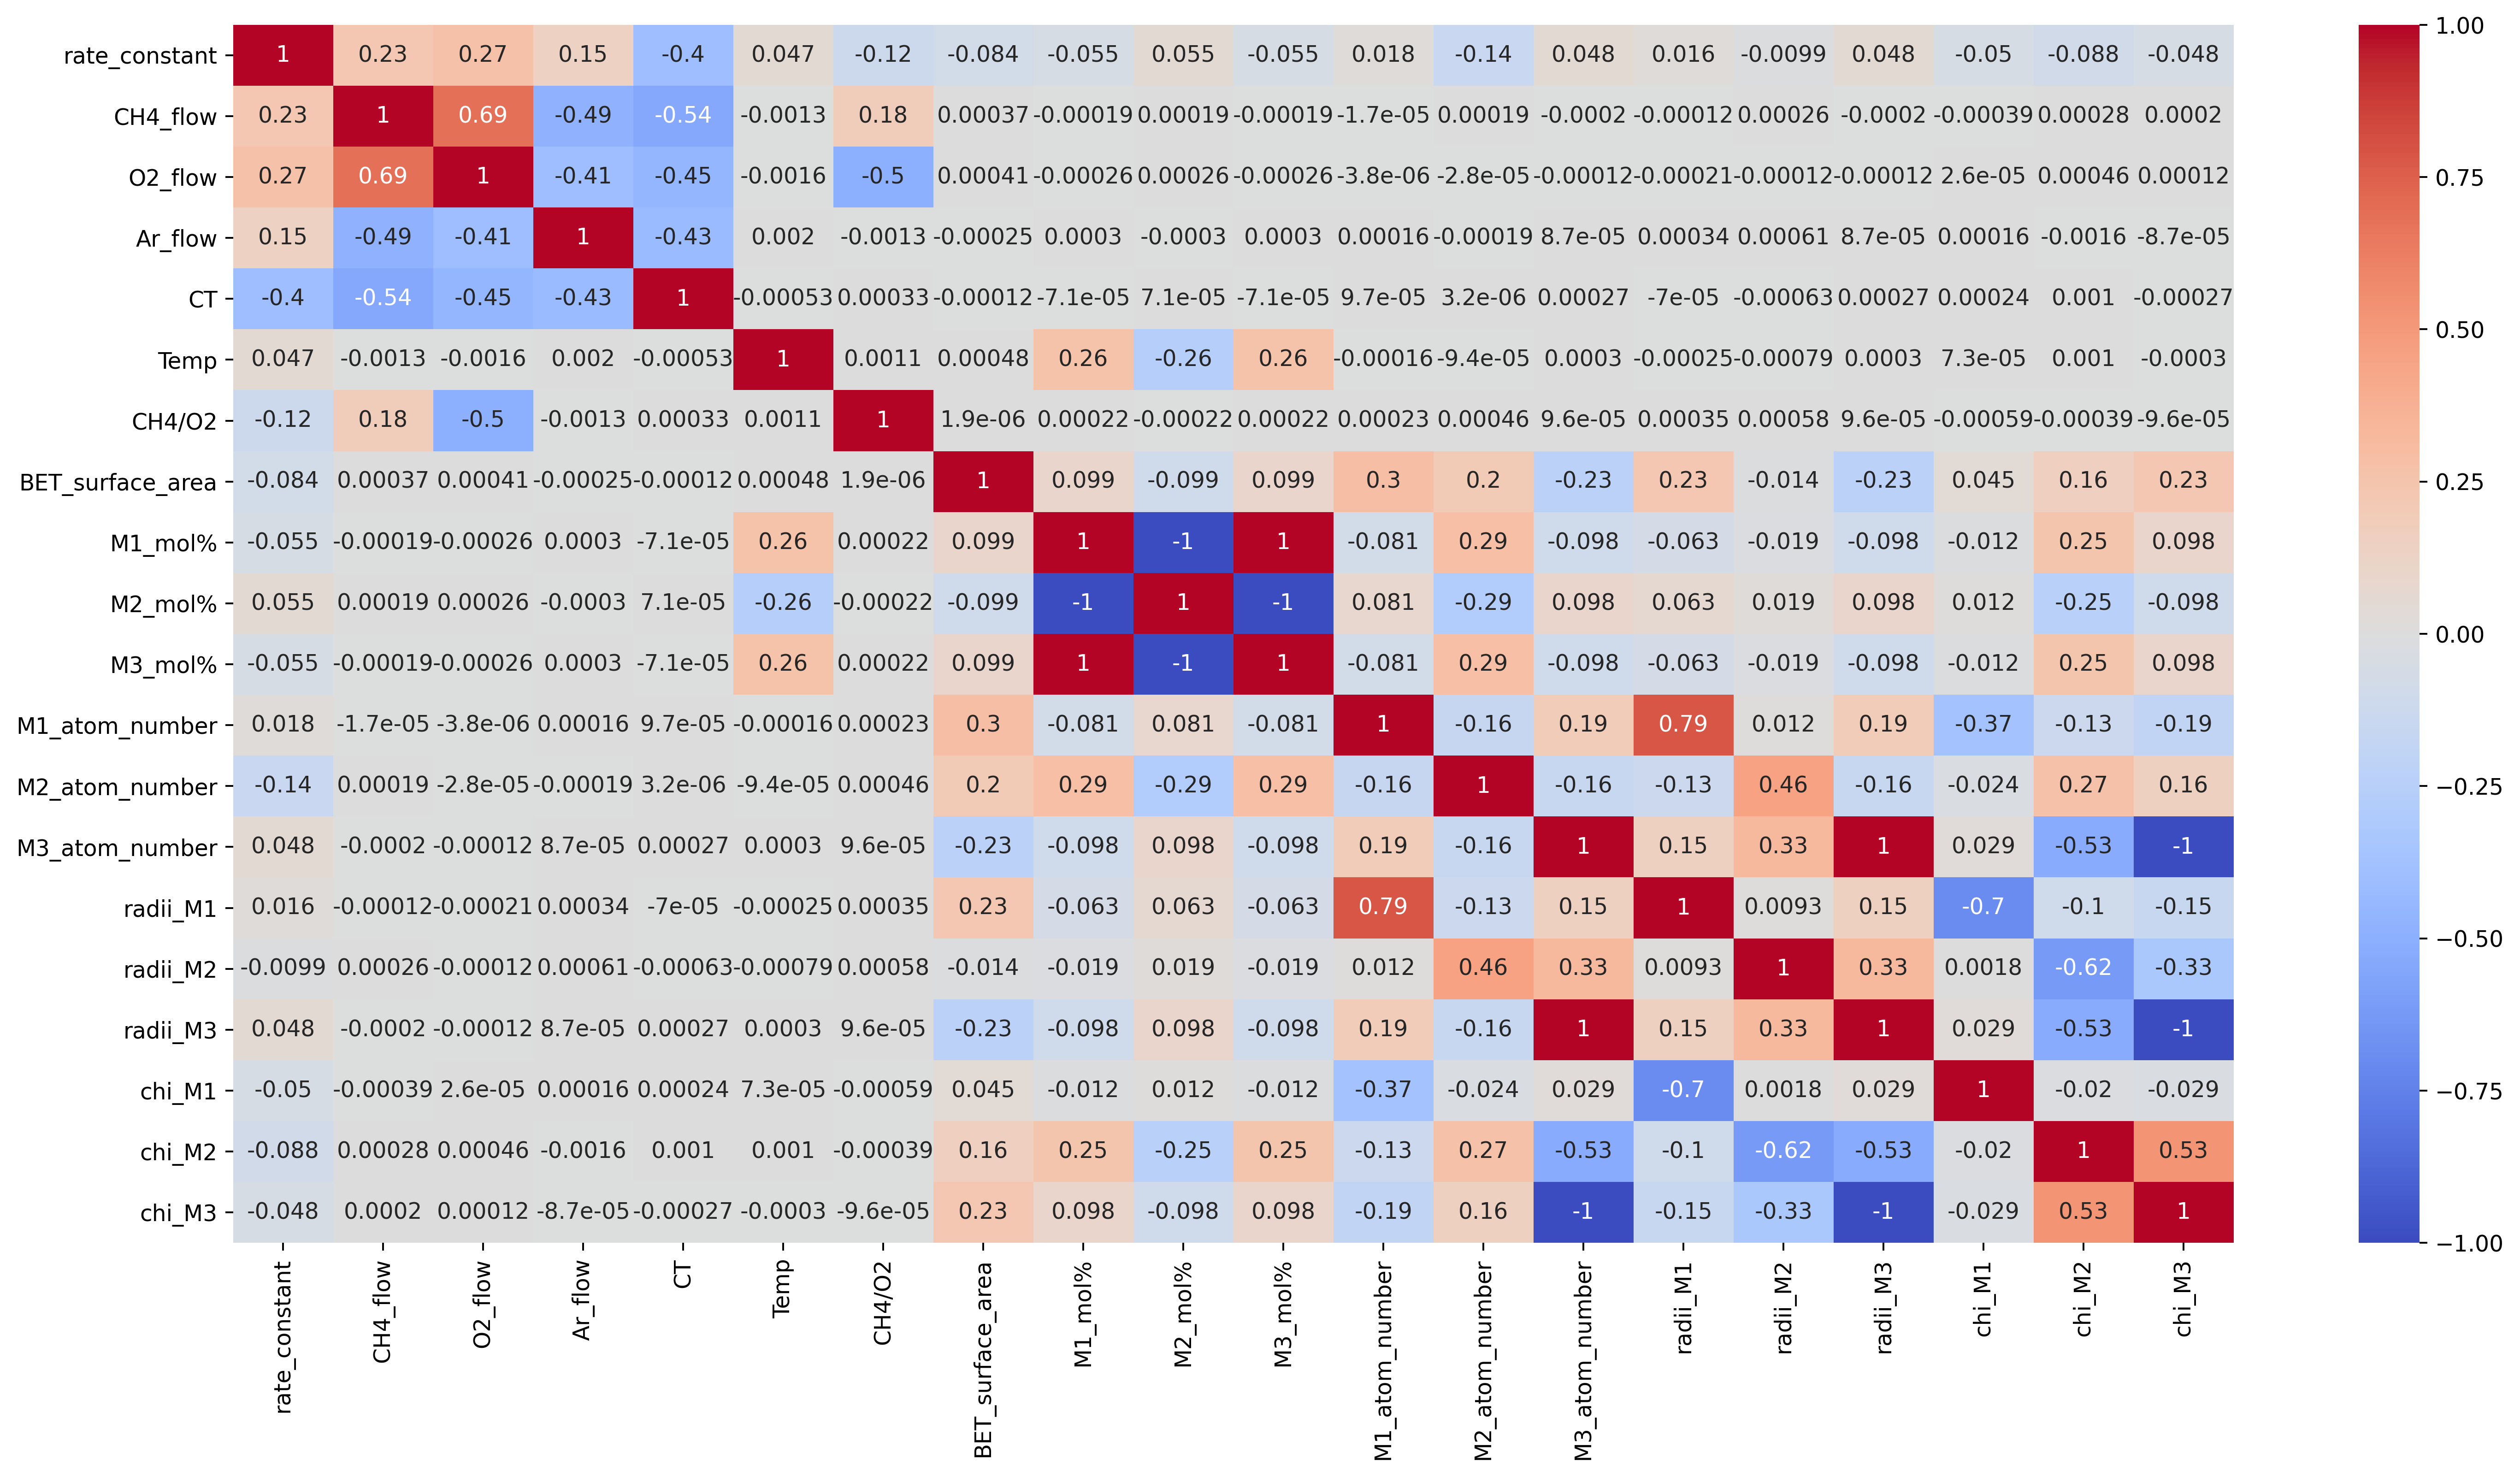

In [13]:
#Idenitfy corelated independent variables through heatmap
import seaborn as sb
corrmat = X_new.corr()
plt.figure(figsize=(20,10), dpi =350)
sb.heatmap(corrmat, cmap = "coolwarm", annot=True)


<Figure size 2100x1400 with 0 Axes>

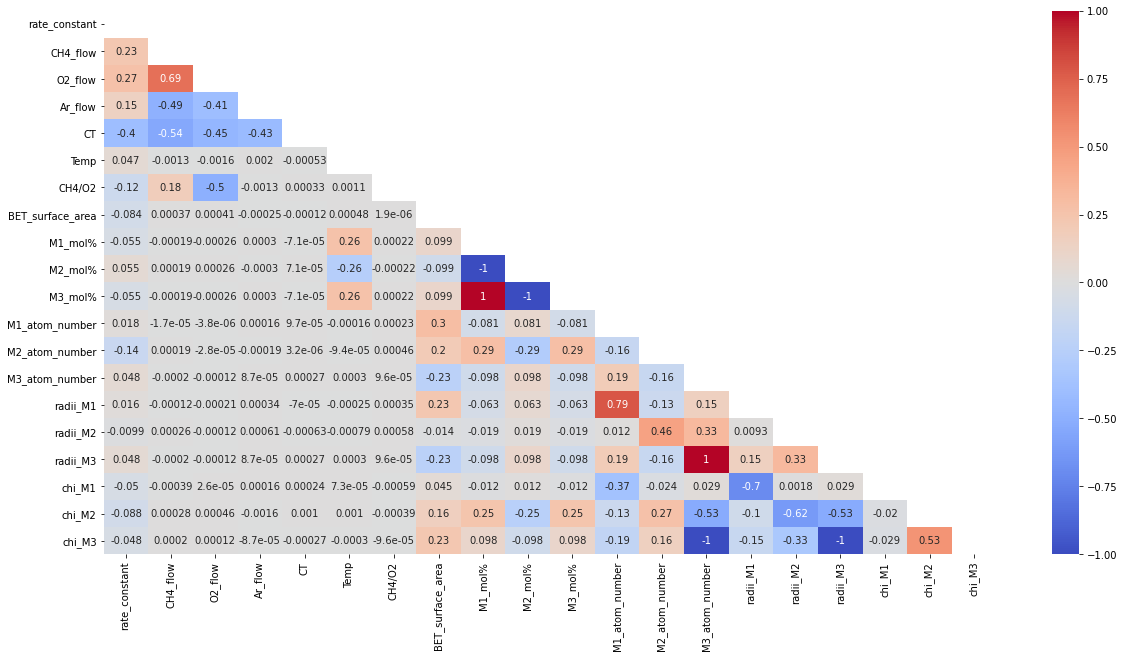

<Figure size 2100x1400 with 0 Axes>

In [14]:
corrmat = X_new.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corrmat)
plt.figure(figsize=(20,10))
# using the upper triangle matrix as mask 
sns.heatmap(corrmat, cmap = "coolwarm", annot=True, mask=matrix)
plt.figure(dpi=350)

# Multiariate Analytics (Dimensionality Reduction & Feature Selection)

In [15]:
import pyphi as phi
import pyphi_plots as pp

In [22]:
#we first begin with 7 PCs
pcaobj = phi.pca( X_raw, 7, mcs=True,
                 md_algorithm='nipals', force_nipals=False, 
                 shush=False, cross_val=5)
#N.B. stoppping criterion: when eigen value is smaller than 1

Cross validating PC #1
Cross validating PC #2
Cross validating PC #3
Cross validating PC #4
Cross validating PC #5
Cross validating PC #6
Cross validating PC #7
phi.pca using NIPALS and cross validation (5%) executed on: 2022-08-24 21:00:54.460166
--------------------------------------------------------------
PC #          Eig      R2X     sum(R2X)      Q2X     sum(Q2X)
PC #1:      4.066    0.226     0.226       0.155     0.155
PC #2:      2.938    0.163     0.389       0.216     0.370
PC #3:      2.283    0.127     0.516       0.096     0.466
PC #4:      1.691    0.094     0.610       0.067     0.534
PC #5:      1.448    0.080     0.690       0.075     0.609
PC #6:      1.427    0.079     0.770       -0.018     0.591
PC #7:      1.008    0.056     0.826       0.188     0.778
--------------------------------------------------------------


In [23]:
#we first begin with 7 PCs
pcaobj = phi.pca(X_raw, 7, mcs=True,
                 md_algorithm='nipals', force_nipals=False, 
                 shush=False, cross_val=0) #we no longer need to cross validate
#N.B. stoppping criterion: when eigen value is smaller than 1

phi.pca using SVD executed on: 2022-08-24 21:03:06.411808
--------------------------------------------------------------
PC #      Eig        R2X       sum(R2X) 
PC #1:      4.066    0.226     0.226
PC #2:      2.938    0.163     0.389
PC #3:      2.283    0.127     0.516
PC #4:      1.691    0.094     0.610
PC #5:      1.448    0.080     0.690
PC #6:      1.427    0.079     0.770
PC #7:      1.008    0.056     0.826
--------------------------------------------------------------


In [24]:
pp.loadings_map(pcaobj,[1,2])

In [25]:
pp.r2pv(pcaobj)
pp.figure

<function bokeh.plotting.figure.figure(**kwargs)>

In [26]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_scatter(pcaobj,[1,2], CLASSID = result, colorby= "Support ",add_ci=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [21]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_line(pcaobj,5, CLASSID = X_raw, colorby= "O2_flow",add_ci=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [42]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_scatter(pcaobj,[1,2], CLASSID = X_raw, colorby= "BET_surface_area",add_ci=True, add_labels=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [25]:
pp.score_scatter(pcaobj,[1,2])

In [175]:
pp.diagnostics(pcaobj)

In [37]:
pp.contributions_plot(pcaobj,X_raw,'spe',to_obs=3711)

In [ ]:
add_ci=False, add_labels=False, add_legend=Tru

In [38]:
pp.score_scatter(pcaobj,[1,2], add_ci=True, add_labels=True, add_legend=True)

In [39]:
pp.weighted_loadings(pcaobj)

In [27]:
#PLS
import pyphi as phi
import pyphi_plots as pp

# Load the data from Excel
condition   = X_raw
rate_constant = y.to_numpy().reshape(-1,1)

#clean data


# Build model
plsobj=phi.pls(condition,rate_constant,5,cross_val=5)


Cross validating LV #1
Cross validating LV #2
Cross validating LV #3
Cross validating LV #4
Cross validating LV #5
phi.pls using NIPALS and cross-validation (5%) executed on: 2022-08-24 21:03:30.656973
---------------------------------------------------------------------------------
PC #       Eig      R2X     sum(R2X)      R2Y     sum(R2Y)      Q2Y     sum(Q2Y)
PC #1:   1.759    0.116     0.116       0.186     0.186       0.185     0.185
PC #2:   3.268    0.191     0.307       0.019     0.205       0.019     0.204
PC #3:   1.081    0.078     0.385       0.003     0.208       0.002     0.206
PC #4:   1.085    0.116     0.501       0.001     0.209       0.001     0.207
PC #5:   0.778    0.085     0.587       0.001     0.210       0.001     0.208
---------------------------------------------------------------------------------


In [28]:
condition,columns_removed_y = phi.clean_low_variances(condition)

# Build model
plsobj=phi.pls(condition ,rate_constant,4,cross_val=0)

#pp.r2pv(plsobj)

phi.pls using SVD executed on: 2022-08-24 21:03:34.135134
--------------------------------------------------------------
LV #     Eig       R2X       sum(R2X)   R2Y       sum(R2Y)
LV #1:    1.759    0.116     0.116      0.186     0.186
LV #2:    3.268    0.191     0.307      0.019     0.205
LV #3:    1.081    0.078     0.385      0.003     0.208
LV #4:    1.085    0.116     0.501      0.001     0.209
--------------------------------------------------------------


In [30]:
pp.score_scatter(plsobj,[1,2], CLASSID = X_raw, colorby= "BET_surface_area", add_ci=True, add_legend=True, plotwidth=650)

In [54]:
pp.weighted_loadings(plsobj)

pp.loadings_map(plsobj,[1,2])

In [31]:
pp.vip(plsobj)

In [13]:
X_new = result[[ "CT", "O2_flow", "Ar_flow", "M2_atom_number", "CH4/O2", "chi_M2"]].to_numpy()
y = result["rate_constant"].to_numpy()

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_new, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6553, 6), (1639, 6), (6553,), (1639,))

# Ridge Regression

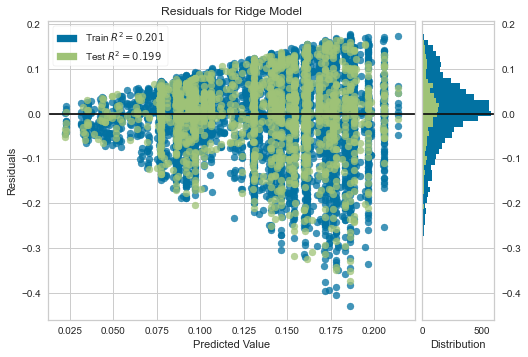

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


# Instantiate the linear model and visualizer
model_ridge = Ridge()
visualizer = ResidualsPlot(model_ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [19]:
y_train_ridge = model_ridge.predict(X_train)
y_test_ridge = model_ridge.predict(X_test)

In [20]:
import math

#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train_ridge,y_train))
te_rmse = math.sqrt(mean_squared_error(y_test_ridge,y_test))
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.082 
Test Set: 0.083 


# Random Forest

In [45]:
# Grid search - tuning hyperparameters of the random forest classifier
rndfor = RandomForestRegressor(random_state = 42)
rndfor.fit(X_raw, y)


RandomForestRegressor(random_state=42)

In [46]:
#Hyperparameter Grid 
parameter_grid = {'max_depth':[2, 4, 6,8, 10, 50],
'n_estimators':[10, 50, 100, 150, 250]}

#Cross-Validated Grid Search
#we're now ready to create our grid-search object. We'll use each the objects we've created thus far.
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(cv=3,
estimator=rndfor ,
param_grid=parameter_grid )

In [47]:
#fit the model
grid_search.fit(X_raw, y)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 50],
                         'n_estimators': [10, 50, 100, 150, 250]})

In [48]:
# Visualise the accuracy score
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032006,0.010878,0.002838,0.000265,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.258771,0.253761,0.342426,0.284986,0.040668,20
1,0.115908,0.006037,0.006497,0.000100,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.260290,0.245958,0.344740,0.283663,0.043583,22
2,0.230224,0.010893,0.011283,0.000571,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.259289,0.245689,0.351013,0.285331,0.046775,19
3,0.327041,0.014717,0.015083,0.000721,2,150,"{'max_depth': 2, 'n_estimators': 150}",0.257540,0.242232,0.350094,0.283289,0.047650,23
4,0.541008,0.024711,0.023688,0.000425,2,250,"{'max_depth': 2, 'n_estimators': 250}",0.257884,0.240887,0.350516,0.283096,0.048176,24
5,0.035689,0.002784,0.002932,0.000145,4,10,"{'max_depth': 4, 'n_estimators': 10}",0.431833,0.297878,0.343364,0.357692,0.055618,9
6,0.168354,0.010149,0.006717,0.000077,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.435657,0.305738,0.348079,0.363158,0.054100,5
7,0.333254,0.020416,0.011686,0.000170,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.435613,0.305941,0.353581,0.365045,0.053556,3
8,0.498685,0.031448,0.016347,0.000330,4,150,"{'max_depth': 4, 'n_estimators': 150}",0.434682,0.307077,0.353976,0.365245,0.052700,2
9,0.833313,0.051765,0.026245,0.000958,4,250,"{'max_depth': 4, 'n_estimators': 250}",0.434398,0.308047,0.355361,0.365935,0.052122,1


In [49]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 4, 'n_estimators': 250}
0.36593515897926543


In [52]:
# From the cell above we decided to use max_depth: 4 and  n_estimators: 250

rndfor_rd = RandomForestRegressor(n_estimators=250, max_depth = 4)
rndfor_rd.fit(X_raw, y)

RandomForestRegressor(max_depth=4, n_estimators=250)

In [53]:
descriptors_list = []
values_list = []
for name, imp in zip(X_raw.columns, rndfor_rd.feature_importances_):
    
    descriptors_list.append(name)
    values_list.append(round(imp,5))
    #get pairs of elements
    zip_iterator = zip(descriptors_list, values_list)


    #convert to dictionary
    dict_descriptors = dict(zip_iterator)


print(dict_descriptors)

{'CH4_flow': 0.0002, 'O2_flow': 0.04446, 'Ar_flow': 0.00483, 'CT': 0.33561, 'Temp': 0.48849, 'CH4/O2': 0.00121, 'BET_surface_area': 0.00538, 'M1_mol%': 0.0, 'M2_mol%': 0.0, 'M3_mol%': 0.0, 'M1_atom_number': 0.00032, 'M2_atom_number': 0.1183, 'M3_atom_number': 0.0, 'radii_M1': 6e-05, 'radii_M2': 0.0, 'radii_M3': 0.0, 'chi_M1': 0.00115, 'chi_M2': 0.0, 'chi_M3': 0.0}


In [54]:
# Table of descriptors in descending order of relative importance
import operator
order = sorted(dict_descriptors.items(),key=operator.itemgetter(1),reverse=True)
order

[('Temp', 0.48849),
 ('CT', 0.33561),
 ('M2_atom_number', 0.1183),
 ('O2_flow', 0.04446),
 ('BET_surface_area', 0.00538),
 ('Ar_flow', 0.00483),
 ('CH4/O2', 0.00121),
 ('chi_M1', 0.00115),
 ('M1_atom_number', 0.00032),
 ('CH4_flow', 0.0002),
 ('radii_M1', 6e-05),
 ('M1_mol%', 0.0),
 ('M2_mol%', 0.0),
 ('M3_mol%', 0.0),
 ('M3_atom_number', 0.0),
 ('radii_M2', 0.0),
 ('radii_M3', 0.0),
 ('chi_M2', 0.0),
 ('chi_M3', 0.0)]

In [55]:
descriptors = []
importance = []
for i in order:
    importance.append(i[1])
    descriptors.append(i[0])
importance[0:11]

[0.48849,
 0.33561,
 0.1183,
 0.04446,
 0.00538,
 0.00483,
 0.00121,
 0.00115,
 0.00032,
 0.0002,
 6e-05]

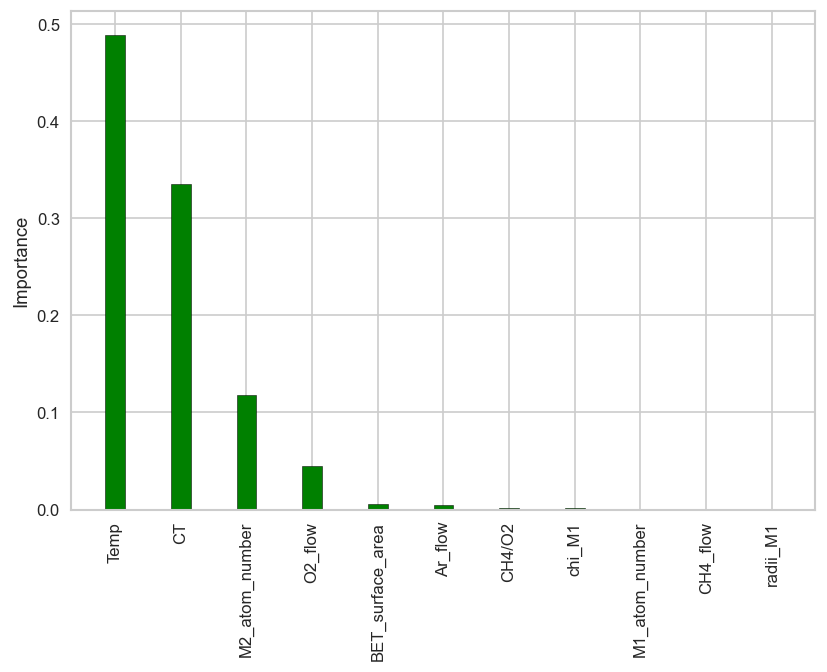

In [56]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
desc = descriptors[0:11]
imp = importance[0:11]


x = np.arange(11)  # the label locations
width = 0.30  # the width of the bars


fig, ax = plt.subplots(1,1,  dpi=120)
impo = ax.bar(x , imp, width, color = 'green', edgecolor= 'black')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Descriptors')
ax.set_ylabel('Importance')
ax.set_aspect('auto')
#ax.set_ylim(0,0.9)
#ax.set_xticks(x, labels)
ax.set_xticks( x, desc,rotation=90,)





#fig.tight_layout()

plt.show()

In [57]:
X_rf = result[[   "Temp",  "O2_flow", "M2_atom_number", "O2_flow"]].to_numpy()
y = result["rate_constant"].to_numpy()

In [58]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = sklearn.model_selection.train_test_split(X_rf, y, test_size=0.20, random_state=42)
X_train_rf.shape, X_test_rf.shape, y_train_rf.shape, y_test_rf.shape


((6553, 4), (1639, 4), (6553,), (1639,))

In [59]:
# From the cell above we decided to use max_depth: 4 and  n_estimators: 250

rndfor_rd = RandomForestRegressor(n_estimators=250, max_depth = 4)
rndfor_rd.fit(X_rf, y)

RandomForestRegressor(max_depth=4, n_estimators=250)

In [60]:
y_rndfor_train = rndfor_rd.predict(X_train_rf)
y_rndfor_test  = rndfor_rd.predict(X_test_rf)

In [61]:
import math
from sklearn.metrics import  mean_squared_error


#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train_rf, y_rndfor_train))
te_rmse = math.sqrt(mean_squared_error(y_test_rf,y_rndfor_test))

print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.072 
Test Set: 0.072 


['$Training \\: set$', '$Test Set$']


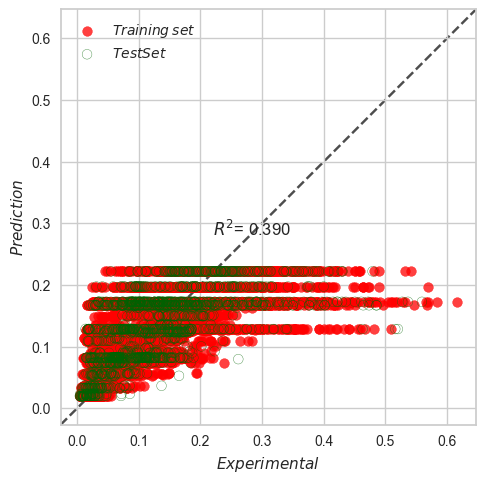

In [62]:
fig, ax = plt.subplots(1,1,  dpi=100)
ax.scatter(y_train_rf, y_rndfor_train,color='red',alpha=0.75,label='$Training \: set$')
ax.scatter(y_test_rf, y_rndfor_test,color='darkgreen',alpha=0.75,label='$Test Set$',facecolors='none')

# Find limits for each axes 
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('$Experimental$')
ax.set_ylabel('$Prediction$')

ax.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test_rf,y_rndfor_test)), (0.40,0.55))
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, labels=labels)

# Symbolic Regression
Once you have collected these features, we can use symbolic regression to automatically identify the most probably features and associated correlation to the kinetic rate coefficient. This will tell us what features are most important for the hydrogenation reaction and how to better design catalysts in future.

# PySR - finding the 'best' model

In [63]:
#model.reset() #we need to re-initialise the model if something went wrong previosuly 
#feel free to comment it out

In [15]:
from pysr import PySRRegressor
model = PySRRegressor(
    
    populations = 100,
    niterations= 100,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[  "cube", "square", "neg",# Custom operator (julia syntax)
    ],
    model_selection="best",
    denoise = True,
    annealing = True                               #loss function: mean squared error 
   

)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.sympy()

In [ ]:
len(model.equations["sympy_format"])

In [ ]:
for i in range(len(model.equations["sympy_format"])):
    print(model.sympy(i))

In [ ]:
X = model.equations["complexity"]
Y = model.equations["loss"]
equations = model.equations["equation"].tolist()
plt.figure(figsize=(20,15))
p = plt.scatter(X,Y,s=100,color="red")
plt.xlabel("Complexity")
plt.ylabel("Loss")
plt.xlim([0, 28])
#plt.ylim([0,0.00001])

for i, label in enumerate(equations):
    plt.annotate(label, (X[i], Y[i])).set_rotation(60)

plt.axis('auto')



plt.show()


In [ ]:
model.sympy()

In [ ]:
y_pysr_train_1 = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x}).predict(X_train)
y_pysr_test_1  = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x}).predict(X_test)

In [ ]:
X_train

In [ ]:
y_pysr_train_1 = model.predict(X_train)
y_pysr_test_1  = model.predict(X_test)

In [ ]:
import math
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import r2_score

#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train, y_pysr_train_1))
te_rmse = math.sqrt(mean_squared_error(y_test, y_pysr_test_1))

tr_r2 = r2_score(y_train, y_pysr_train_1)
te_r2 = r2_score(y_test, y_pysr_test_1)
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))
print("R2 Scores:")
print("Training Set: {:.3f} ".format(tr_r2))
print("Test Set: {:.3f} ".format(te_r2))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
ax.scatter(y_train, y_pysr_train_1,color='red',alpha=0.75,label='$Training \: set$')
ax.scatter(y_test, y_pysr_test_1,color='darkgreen',alpha=0.5,label='$Test Set$',facecolors='none')

# Find limits for each axes 
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('$Experimental$')
ax.set_ylabel('$Prediction$')

ax.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test, y_pysr_test_1)), (0.25,0.32))
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, labels=labels)


In [ ]:
#parity plot 
plt.figure(dpi=100)
plt.xlabel('$Experimental$',fontsize=8)
plt.ylabel('$Prediction$',fontsize=8)
x = np.linspace(min(y_train), max(y_train), 1000)
plt.plot(x, x+0, 'black')
plt.scatter(y_train, y_pysr_train_1,color='red',alpha=0.75,label='$Training \: set$')
plt.scatter(y_test, y_pysr_test_1,color='darkgreen',alpha=0.5,label='$Test \: set$',facecolors='none')
plt.legend(fontsize=8,loc=4)
plt.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test, y_pysr_test_1)), (0.14, 0.20))
plt.axis('square')
plt.show()

# QLattice

In [22]:
OCM_new = result[[ "CT", "O2_flow", "Ar_flow", "M2_atom_number", "CH4/O2", "chi_M2","rate_constant"]]

In [23]:
import feyn

ql = feyn.QLattice()

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [24]:

train, test = train_test_split(OCM_new, test_size=0.2, random_state=42)

In [25]:
# Instantiate a QLattice
ql = feyn.QLattice(random_seed=42)

# Sample and fit models
models = ql.auto_run(
    data=train,
    output_name='rate_constant',
    kind='regression',

)


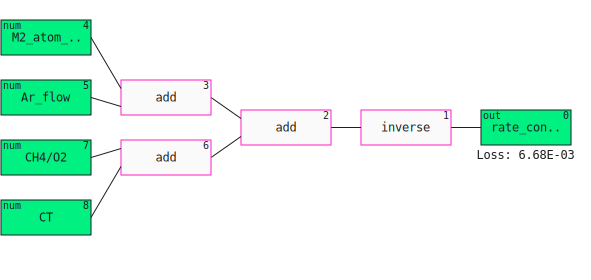

In [26]:
models[0]

In [27]:
models[0].sympify()

0.000238481 + 0.419136/(0.0126831*Arflow + 0.147588*CH4/O2 + 6.51518*CT + 0.0348935*M2atomnumber - 1.22741)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="368.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 875 368.0" width="875" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="110.0"><title>rate_constant
linear:
scale=0.306162
scale offset=0.000000
w=1.369001
bias=0.0008</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="131.5">rate_con..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="119.0">out</text><line stroke="#1E1E1E" x1="451" x2="481" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="110.0"><title>inverse</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">inverse</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">2</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>M2_atom_number
linear:
scale=0.037736
scale offset=14.010987
w=0.924678
bias=1.7724</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">M2_atom_..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>Ar_flow
linear:
scale=0.160000
scale offset=6.219426
w=0.079269
bias=0.2257</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">Ar_flow</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="
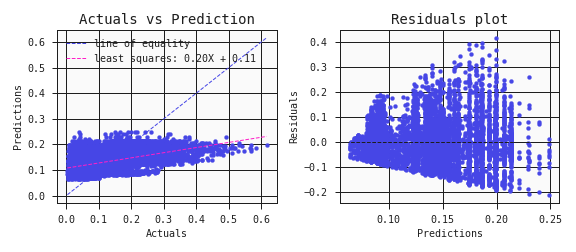
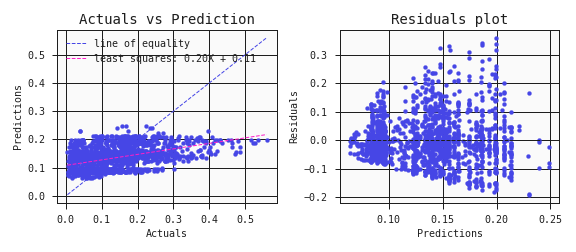

In [28]:
# Select the best Model
best = models[0]
best.plot(
    data=train,
    compare_data=test
)